# Generalities

First things first,
The complete dataset is spread through different tables in .xls format. To have one file that contains everything I used an xcel's algorithm called lookup. But the lookup only works under certain conditions that needed to be checked first. These conditions are:
+ Check the quantity of client/clientID s that we are going to be working with
+ Check that throughout all the tables there's only one clientID amd there's no more than 1615 clients in total
+ Check that the clientID is not a negative number
+ Verify that there's one clientID row at most

Afterwards, a lookup would be done to have all the information of certain client in one place. This will be our main dataset, also called "ful_dataset.csv" in the code.


# Data exploration. First rule of Machine Learning: know your data

In [562]:
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer #replace missing values with the mean of each column
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

Following is the main dataset to work with

In [412]:
#the main.csv is the file that contains all the tables together!
kbc_bank_info 	= pd.read_csv('/Users/Fernando/Documents/Jobs/KBC/data_science/full_dataset.csv')

Dataset for the positive target values credits, loans, and mutual funds

In [403]:
cust_req = pd.DataFrame({'Category': {0: 'Credit', 1: 'Loan',2:'Mutual Fund'}, 'Sum': {0: float(kbc_bank_info[["Sale_CC"]].sum()),1:float(kbc_bank_info[["Sale_CL"]].sum()),2:float(kbc_bank_info[["Sale_MF"]].sum()) }})

In [404]:
print(kbc_bank_info[["Sale_CC"]].sum())


Sale_CC    242.0
dtype: float64


In [405]:
print(kbc_bank_info[["Sale_CL"]].sum())


Sale_CL    290.0
dtype: float64


In [406]:
print(kbc_bank_info[["Sale_MF"]].sum())


Sale_MF    193.0
dtype: float64


In [407]:
%matplotlib inline


Following: sales target in order to see the requirement of the consumers

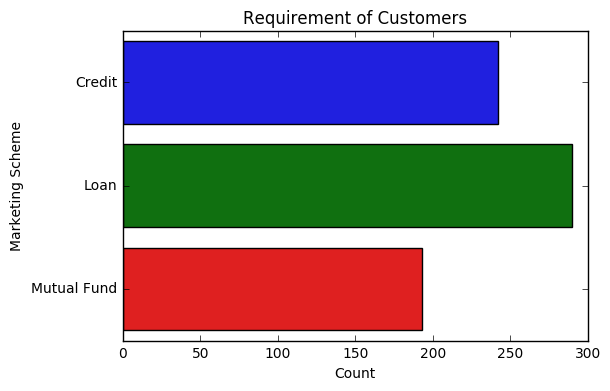

In [408]:
sns.barplot(x = 'Sum', y = 'Category', data = cust_req)
plt.title('Requirement of Customers')
plt.xlabel('Count')
plt.ylabel('Marketing Scheme')

We have a bunch of data and we need to make 3 models:
+ one model to predict customers (clients) who will buy consumer loan
+ one model to predict customers (clients) who will buy credit card
+ one model to predict customers (clients) who will buy mutual fund

And it is also necessary to predict revenue based on all the previous models.

To acomplish these goals we need to create a propensity function as well. The 
propensity function will calculate the probability values for every row in our dataframe.

# Which clients have higher propensity to buy consumer loan?

How much of our data is null/missing

In [413]:
print(dataset.isnull().sum())

Client                          0
Count_CA                        0
Count_SA                        1
Count_MF                        2
Count_OVD                       0
Count_CC                        3
Count_CL                        5
ActBal_CA                       0
ActBal_SA                       1
ActBal_MF                       2
ActBal_OVD                      0
ActBal_CC                       3
ActBal_CL                       5
Gender                          0
Age                             0
Tenure                          0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashless_Card          0
VolumeDeb_PaymentOrder          0
TransactionsDeb                 0
TransactionsDeb_CA              0
TransactionsDebCash_Card        0
TransactionsDebCashless_Card    0
TransactionsDe

We could drop all the data that is missing using dropna(). Nonetheless, there are better ways to work with missing data, in particular to use the fillna to try to fill as much blank spaces as we can, and only then drop what we see is missing. 

In [415]:
dataset = dataset.fillna(method='pad')

In [417]:
dataset = dataset.dropna()

Now we check that we do not have null values in our rows, otherwise we'll have problems in the future

In [418]:
print(dataset.isnull().sum())

Client                          0
Count_CA                        0
Count_SA                        0
Count_MF                        0
Count_OVD                       0
Count_CC                        0
Count_CL                        0
ActBal_CA                       0
ActBal_SA                       0
ActBal_MF                       0
ActBal_OVD                      0
ActBal_CC                       0
ActBal_CL                       0
Gender                          0
Age                             0
Tenure                          0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashless_Card          0
VolumeDeb_PaymentOrder          0
TransactionsDeb                 0
TransactionsDeb_CA              0
TransactionsDebCash_Card        0
TransactionsDebCashless_Card    0
TransactionsDe

In [419]:
dataset.shape

(1611, 36)


We calculate the correlation between the Sale_CL attribute with the other attributes, and then decide (using a threshold) which features we are gonna use in the prediction

In [420]:
corr = dataset.corr()
corr.sort_values(["Sale_CL"], ascending = False, inplace = True)
print(corr.Sale_CL)

Sale_CL                         1.000000
Revenue_CL                      0.656429
Tenure                          0.112517
ActBal_OVD                      0.071493
TransactionsDebCash_Card        0.058354
TransactionsCred                0.057450
TransactionsCred_CA             0.056456
Client                          0.050874
Count_CA                        0.042853
Sale_MF                         0.038160
TransactionsDeb                 0.033412
TransactionsDeb_CA              0.029751
TransactionsDeb_PaymentOrder    0.027393
VolumeDeb_CA                    0.023782
VolumeDeb                       0.022064
VolumeDeb_PaymentOrder          0.020640
VolumeDebCash_Card              0.018990
ActBal_CL                       0.017983
VolumeDebCashless_Card          0.016550
Revenue_MF                      0.008548
VolumeCred                      0.004401
ActBal_MF                       0.001684
VolumeCred_CA                  -0.000677
ActBal_SA                      -0.006125
ActBal_CC       


We choose the correlated fields to create the dataset to be used in the prediction (data_loan). Of course the Revenue_CL is not chosen since it's the target variable. 

In [568]:
data_loan = dataset[['Tenure','TransactionsCred_CA','Count_CA','TransactionsCred','TransactionsDebCash_Card','ActBal_CC','Age','Client','Sale_CL','Revenue_CL']]

As conventional, X as features and y targets (used for train)

In [569]:
X = data_loan.ix[:,'Tenure':'Client'].as_matrix()
y = data_loan.Sale_CL.as_matrix()

Correlation matrix heatmap

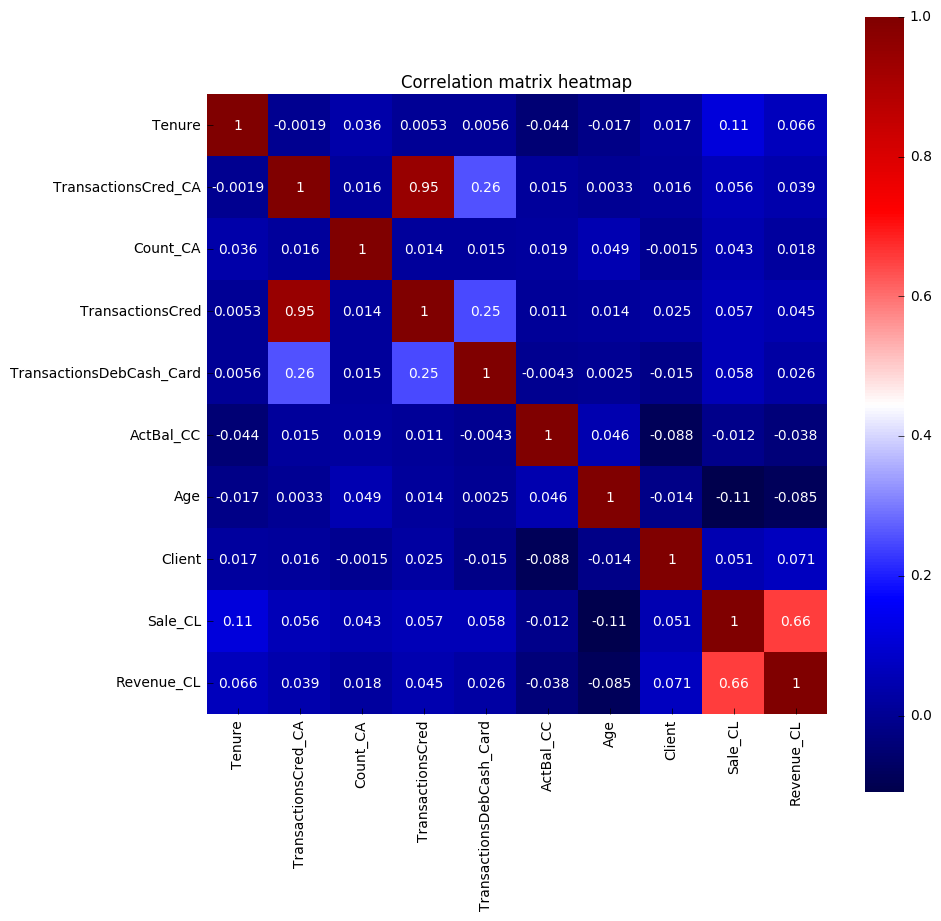

In [570]:
Corr_Loan = data_loan.corr()
plt.figure(figsize=(10,10))
sns.heatmap(Corr_Loan, vmax=1, square=True,annot=True,cmap='seismic')

plt.title('Correlation matrix heatmap')

Split the dataset into training and testing datasets, with their Xs (features) and ys (targets). 

The test_size = 0.15 is not chosen randomly, this is a condition of the problem (The bank has capacity to contact only 15 pct. of the clients (cca 100 people))

In [571]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.15, random_state=42)


Logistic regression as classification algorithm. It's simple enough and it will converge quickly since we don't have
such a huge dataset.

In [572]:
logistic = linear_model.LogisticRegression(penalty='l2',C=1,class_weight='balanced')
logistic = logistic.fit(X_train, y_train)

In [573]:
print("Accuracy = "+str(logistic.score(X_test,y_test)))


Accuracy = 0.570247933884


Almost 60% of accuracy (not bad). Now we need our propensity values; therefore we need a propensity function.

This function assigns the propensity of each client to buy the consumer loan.


In [428]:
pscore = logistic.predict_proba(X_test)[:,1] # The predicted propensities by the model


In [429]:
Clients = X_test[:,-1]


In [430]:
def map_score(dataframe,customers,prob):
    dataframe['Propensity'] = 0
    for i in range(len(dataframe)):
        idx = dataframe.index[i]
        for j in range(len(customers)):
            if dataframe.loc[idx,'Client'] == customers[j]:
                dataframe.loc[idx, "Propensity"] = prob[j]

In [578]:
map_score(data_loan,Clients,pscore)


Removing the values where the Sale_CL = 0 

to contact only those customer who are suitable candidates for loan. 

In [581]:
# Remove records where the Target sale value is 0
data_loan =data_loan[(data_loan.Sale_CL != 0)]

# Remove cases where probability is 0
data_loan = data_loan[(data_loan.Propensity != 0)]

# Remove the non essential fields 
data_loan = data_loan[['Client','Sale_CL','Revenue_CL','Propensity']]

# Sort the values by Decreasing order of Propensity, so that the clients with the highest propensity can be targeted first
Clients_loan = data_loan.sort_values(by ='Propensity',ascending=False)


And then we see the results!

In [438]:
data_loan

,Client,Sale_CL,Revenue_CL,Propensity
72,73.0,1.0,18.353929,0.339416
81,82.0,1.0,5.396429,0.544885
83,84.0,1.0,28.685357,0.529832
120,121.0,1.0,7.297857,0.436894
128,129.0,1.0,6.138929,0.463063
146,147.0,1.0,15.613214,0.555816
178,179.0,1.0,14.138571,0.522410
180,181.0,1.0,12.943571,0.264340
225,226.0,1.0,8.130714,0.373975
244,245.0,1.0,5.685357,0.576059


This is not really asked, but it's nice to have this information saved somewhere

In [582]:
Clients_loan.to_csv('Clients_loan.csv',index=False)

# Which clients have higher propensity to buy credit card?


Now we need to do something very similar to the previous step.

But now, we take into consideration the consumer credit; for this we use the Sale_CC

In [583]:
corr.sort_values(["Sale_CC"], ascending = False, inplace = True)
print(corr.Sale_CC)

Sale_CC                         1.000000
Revenue_CC                      0.250480
ActBal_CA                       0.101748
Revenue_CL                      0.054494
ActBal_MF                       0.043527
ActBal_SA                       0.041597
TransactionsDebCash_Card        0.036714
VolumeDeb_PaymentOrder          0.034179
Age                             0.033208
VolumeDeb                       0.019144
TransactionsCred                0.017552
VolumeDeb_CA                    0.011045
TransactionsDeb                 0.011026
Count_CL                        0.010708
TransactionsDeb_PaymentOrder    0.008841
Tenure                          0.004603
Count_MF                       -0.000027
TransactionsCred_CA            -0.001743
TransactionsDeb_CA             -0.002497
TransactionsDebCashless_Card   -0.002895
Client                         -0.005726
Count_SA                       -0.009465
VolumeCred                     -0.012428
VolumeDebCash_Card             -0.013949
VolumeDebCashles

Picking the features for the classification algorithm

In [597]:
#data_credit = dataset[['Client', 'Sale_CC', 'Revenue_CC', 'ActBal_SA', 'ActBal_CA', 'VolumeDeb_PaymentOrder', 'ActBal_CC', 'ActBal_MF', 'ActBal_OVD','Count_MF']]
data_credit = dataset[['ActBal_SA','ActBal_CA','Count_SA','VolumeDeb_PaymentOrder','TransactionsDebCash_Card','ActBal_CC','Count_CC','Client','Sale_CC','Revenue_CC']]

Now we separate the features from the target in the df

In [598]:
X = data_credit.ix[:,'ActBal_SA':'Client'].as_matrix()
y = data_credit.Sale_CC.as_matrix()

Correlation Matrix (always nice to have/see)

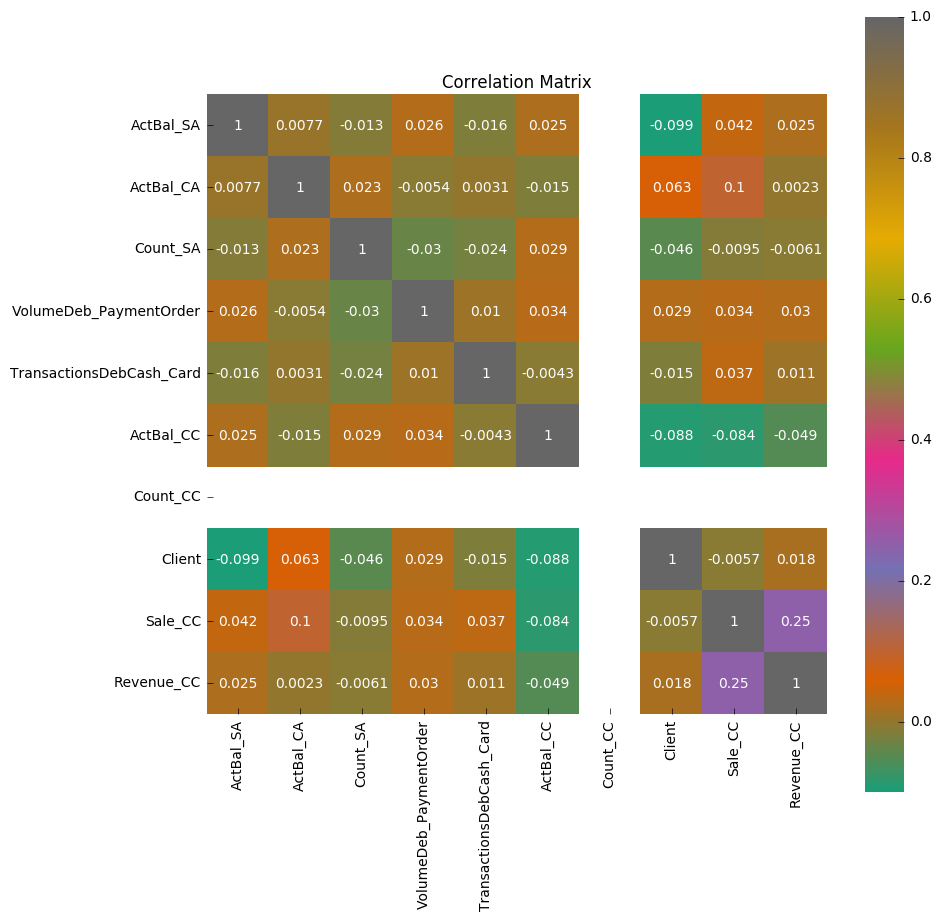

In [599]:
Corr_Credit = data_credit.corr()
plt.figure(figsize=(10,10))
sns.heatmap(Corr_Credit, vmax=1, square=True,annot=True,cmap='Dark2')

plt.title('Correlation Matrix')


Again the necessary step of spliting the dataset into training and targeting (with their respective values, and using cross-validation to avoid overfitting).

In [600]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.15, random_state=42)

Using Random Forest (a bunch of decision tress) in this case. No particular reason to choose this algorithm since 
there's no condition or limititation about it

In [601]:
clf = clf.fit(X_train, y_train)

In [602]:
print(clf.score(X_test,y_test))


0.764462809917


The accuracy obtained is high enough, which indicates a good generalization of the function.

Now let's test the propensity function for this case!.

In [603]:
pscore = clf.predict_proba(X_test)[:,1]
# The list of clients to be mapped to the propensity score calculated
Clients = X_test[:,-1]

Mapping the propensity to every dataframe's row

In [605]:
map_score(data_credit,Clients,pscore)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

KeyboardInterrupt: 

What we have:

In [606]:
data_credit

,ActBal_SA,ActBal_CA,Count_SA,VolumeDeb_PaymentOrder,TransactionsDebCash_Card,ActBal_CC,Count_CC,Client,Sale_CC,Revenue_CC,Propensity
5,8079.715714,4.297143,1.0,0.000000,1.0,1110.381786,1.0,6.0,0.0,0.000000,0.000000
6,8079.715714,879.685000,1.0,10.714286,1.0,1110.381786,1.0,7.0,0.0,0.000000,0.000000
7,8079.715714,0.000000,1.0,0.000000,10.0,1110.381786,1.0,8.0,0.0,0.000000,0.000000
8,8079.715714,510.166429,1.0,170.714286,1.0,1110.381786,1.0,9.0,0.0,0.000000,0.000000
9,116.709286,253.458929,1.0,0.000000,0.0,1110.381786,1.0,10.0,0.0,0.000000,0.000000
10,5.590357,709.902500,1.0,0.000000,3.0,1110.381786,1.0,11.0,0.0,0.000000,0.000000
11,5.590357,1075.475000,1.0,87.535714,1.0,1110.381786,1.0,12.0,0.0,0.000000,0.000000
12,5.832500,353.839643,1.0,312.535714,6.0,1110.381786,1.0,13.0,0.0,0.000000,0.000000
13,403.659286,23.344643,1.0,383.535714,5.0,53.132143,1.0,14.0,0.0,0.000000,0.000000
14,403.659286,1.545357,1.0,0.000000,0.0,53.132143,1.0,15.0,0.0,0.000000,0.000000


More cleaning (taking the columns we are more interested in) and also seeing which clients are really suitable

In [607]:
# Remove records where the Target sale value is 0
data_credit =data_credit[(data_credit.Sale_CC != 0)]
# Remove cases where probability is 0
data_credit = data_credit[(data_credit.Propensity != 0)]
# Remove the non essential fields 
data_credit = data_credit[['Client','Sale_CC','Revenue_CC','Propensity']]
# Sort the values by Decreasing order of Propensity, so that the clients with the highest propensity can be targeted first
Clients_credit = data_credit.sort_values(by ='Propensity',ascending=False)

In [530]:
Clients_credit


,Client,Sale_CC,Revenue_CC,Propensity
410,411.0,1.0,7.000000,1.000000
371,372.0,1.0,1.786786,0.995298
355,356.0,1.0,3.607143,0.401089
430,431.0,1.0,2.714286,0.123552
388,389.0,1.0,37.233214,0.120270
387,388.0,1.0,37.233214,0.118353
104,105.0,1.0,12.256429,0.112382
305,306.0,1.0,5.357143,0.111750
321,322.0,1.0,1.785714,0.107410
357,358.0,1.0,3.607143,0.106287


And nice and good practice, export your results to a more readable format

In [ ]:
# Export the results to a CSV file
Clients_credit.to_csv('Clients_credit.csv',index=False)

# Which clients have higher propensity to buy mutual fund?


Similar to the two previous cases, we need to study correlation; but now with respect to the Mutual Fund, so the 
feature would be: Sale_MF

In [531]:
corr.sort_values(["Sale_MF"], ascending = False, inplace = True)
print(corr.Sale_MF)

Sale_MF                         1.000000
Revenue_MF                      0.387061
Count_MF                        0.071219
Revenue_CL                      0.063829
Client                          0.053897
TransactionsDebCashless_Card    0.051075
ActBal_CL                       0.045752
TransactionsCred_CA             0.040574
TransactionsCred                0.039507
Sale_CL                         0.038160
TransactionsDeb                 0.034967
ActBal_CA                       0.023920
Count_SA                        0.014576
TransactionsDeb_CA              0.011402
ActBal_SA                       0.005952
TransactionsDeb_PaymentOrder    0.002332
Count_CL                       -0.000106
VolumeDebCashless_Card         -0.001240
ActBal_CC                      -0.001520
VolumeCred_CA                  -0.009979
Count_CA                       -0.010220
TransactionsDebCash_Card       -0.012645
Tenure                         -0.018255
ActBal_MF                      -0.019765
VolumeCred      

The reduced dataset is taken from these features, using a threshold we can see which features are correlated and whic
ones we can ignore.

In [532]:
data_mutual_fund = dataset[['Count_MF','TransactionsDebCashless_Card','TransactionsDeb','TransactionsCred_CA'             
,'TransactionsCred','TransactionsDeb_CA','ActBal_MF',
'TransactionsDeb_PaymentOrder','VolumeCred_CA','Client','Sale_MF','Revenue_MF']]

In [533]:
data_mutual_fund.shape

(1611, 12)

X array contains the features


y array contains the targets

In [534]:
X = data_mutual_fund.ix[:,'Count_MF':'Client'].as_matrix()
y = data_mutual_fund.Sale_MF.as_matrix()

Correlation matrix

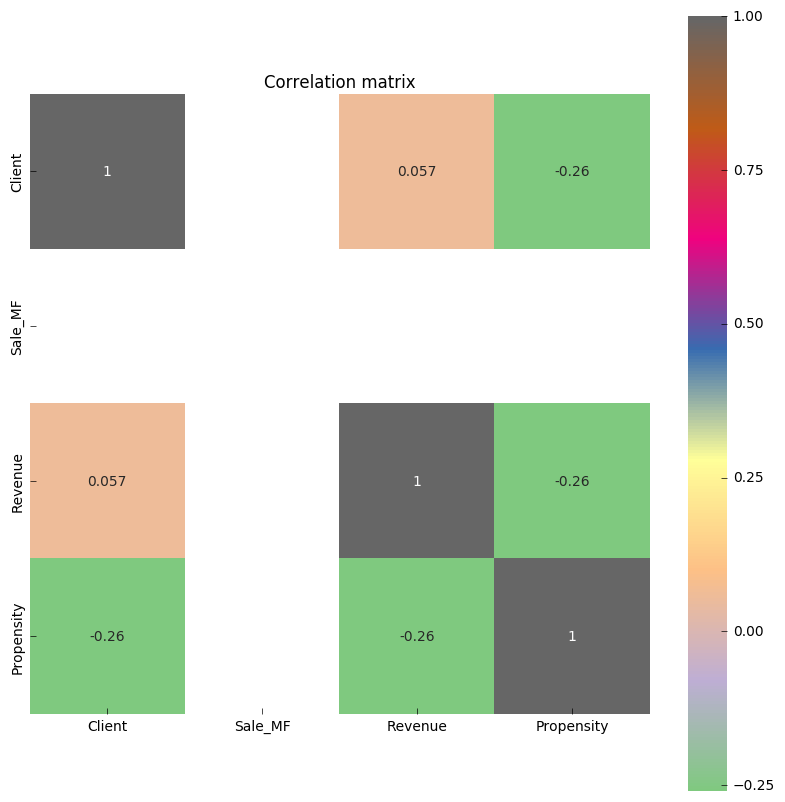

In [608]:
Corr_Mutual_Fund = data_mutual_fund.corr()
plt.figure(figsize=(10,10))
sns.heatmap(Corr_Mutual_Fund, vmax=1, square=True,annot=True,cmap='Accent')

plt.title('Correlation matrix')

In this case GaussianNB was choosen it is suitable for binary events and out target value is Binary(0/1)

Spliting using cross-validation values; 

Also in this case we used Naive Bayes, and GaussianNB() among MultinominalNB() and BernoulliNB()

In [536]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.15, random_state=42)
clf = GaussianNB()
clf.fit(X_train,y_train)

GaussianNB(priors=None)

In [537]:
print(clf.score(X_test,y_test))


0.785123966942


A good accuracy in the model; let's study the propensity

In [538]:
pscore = clf.predict_proba(X_test)[:,1]


In [544]:
Clients = X_test[:,-1]
map_score(data_mutual_fund,Clients,pscore)

In [545]:
data_mutual_fund

,Client,Sale_MF,Revenue_MF,Propensity
35,36.0,1.0,0.238036,0.032264
74,75.0,1.0,0.004821,0.983882
128,129.0,1.0,28.295536,0.153175
129,130.0,1.0,0.067143,0.457142
167,168.0,1.0,1.703214,0.176105
208,209.0,1.0,0.260714,0.147821


In [546]:
# Remove records where the Target sale value is 0
data_mutual_fund =data_mutual_fund[(data_mutual_fund.Sale_MF != 0)]
# Remove cases where probability is 0
data_mutual_fund = data_mutual_fund[(data_mutual_fund.Propensity != 0)]
# Remove the non essential fields 
data_mutual_fund = data_mutual_fund[['Client','Sale_MF','Revenue_MF','Propensity']]
# Sort the values by Decreasing order of Propensity, so that the clients with the highest propensity can be targeted first
Clients_mutual_fund = data_mutual_fund.sort_values(by ='Propensity',ascending=False)


In [ ]:
# Export the results to a CSV file
Clients_mutual_fund.to_csv('Clients_mutual_fund.csv',index=False)

In [547]:
Clients_mutual_fund

,Client,Sale_MF,Revenue_MF,Propensity
74,75.0,1.0,0.004821,0.983882
129,130.0,1.0,0.067143,0.457142
167,168.0,1.0,1.703214,0.176105
128,129.0,1.0,28.295536,0.153175
208,209.0,1.0,0.260714,0.147821
35,36.0,1.0,0.238036,0.032264


# Comparison between the three cases

In [548]:
print("Revenue From sale of Credit Card   = " +str(data_credit.Revenue_CC.sum()))
print("Revenue From sale of Consumer Loan = " +str(data_loan.Revenue_CL.sum()))
print("Revenue From sale of Mutual Fund   = " +str(data_mutual_fund.Revenue_MF.sum()))

Revenue From sale of Credit Card   = 136.368928578
Revenue From sale of Consumer Loan = 444.087142863
Revenue From sale of Mutual Fund   = 30.569464282


In [549]:
print("Total best case Revenue = " +str(data_credit.Revenue_CC.sum() + data_loan.Revenue_CL.sum() + data_mutual_fund.Revenue_MF.sum()))

Total best case Revenue = 611.025535723


consolidation of results
This new dataset will contain the results for the future.

In [550]:
data_credit.rename(columns={'Revenue_CC': 'Revenue'}, inplace=True)
data_loan.rename(columns={'Revenue_CL': 'Revenue'}, inplace=True)
data_mutual_fund.rename(columns={'Revenue_MF': 'Revenue'}, inplace=True)

In [557]:
Consolidated_data = data_credit[["Client","Revenue",'Propensity']].copy()
Consolidated_data['Category'] = 'Credit'
Consolidated_data = Consolidated_data.append(data_loan)
Consolidated_data = Consolidated_data[['Category','Client','Revenue','Propensity']]
Consolidated_data = Consolidated_data.fillna('')

Consolidated_data = Consolidated_data.append(data_mutual_fund)
Consolidated_data = Consolidated_data[['Category','Client','Revenue','Propensity']]
Consolidated_data = Consolidated_data.fillna('mutual_fund')

#Consolidated_data = Consolidated_data.replace('', np.NaN)
#Consolidated_data.dropna()

Now we may amplify our data exploration (*know your data*) 

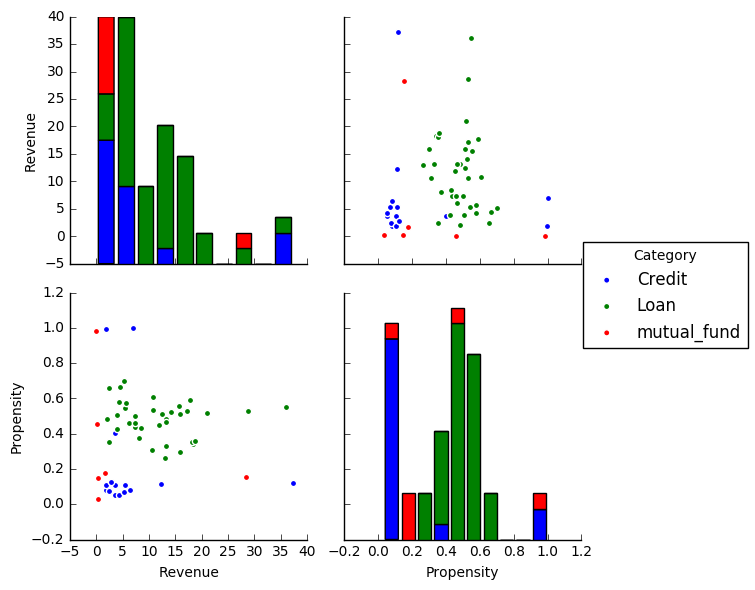

In [609]:
sns.pairplot(Consolidated_data.drop("Client", axis=1), hue="Category", size=3)


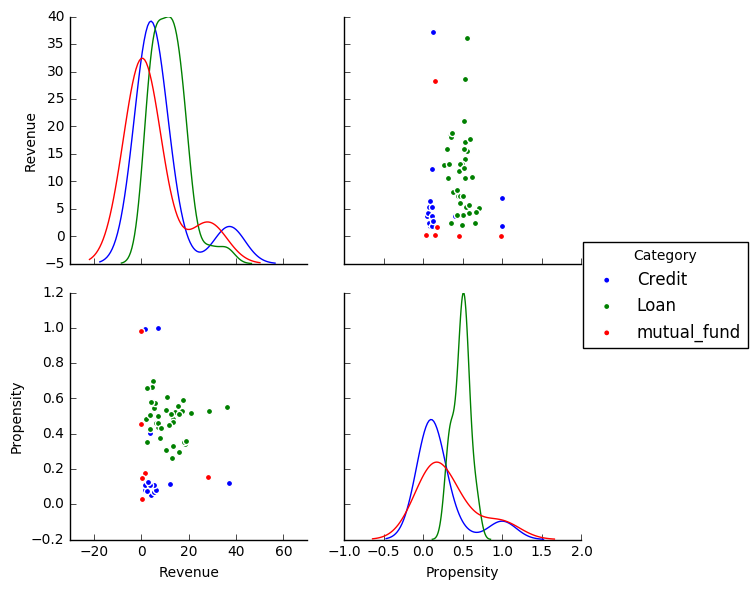

In [610]:
sns.pairplot(Consolidated_data.drop("Client", axis=1), hue="Category", size=3, diag_kind="kde")


# Maximize the revenues

Customers with high propensity for buying credits/loans, etc are those which will have higher revenues. 
Clients with a propensity higher than a certain threshold (0.50) will received an offer. This could be by calling them
or with another kind of communication selected by the preference of the bank.

In [558]:
Consolidated_data['Category'].value_counts()


Loan           38
Credit         16
mutual_fund     6
Name: Category, dtype: int64

In [559]:
CallTheseClients = Consolidated_data[(Consolidated_data.Propensity>=0.50)]


In [560]:
CallTheseClients = CallTheseClients.sort_values(by =['Category','Propensity'],ascending=False)
CallTheseClients

,Category,Client,Revenue,Propensity
74,mutual_fund,75.0,0.004821,0.983882
302,Loan,303.0,5.178571,0.699330
495,Loan,496.0,4.488214,0.665126
556,Loan,557.0,2.380714,0.657191
484,Loan,485.0,10.809643,0.609582
543,Loan,544.0,17.785714,0.589840
476,Loan,477.0,4.214286,0.578592
244,Loan,245.0,5.685357,0.576059
146,Loan,147.0,15.613214,0.555816
416,Loan,417.0,36.050714,0.550754


Revenue = Group the data by category and sum up the revenues

In [561]:
Expected_Revenue = CallTheseClients.groupby(by=['Category'],as_index=False)['Revenue'].sum()
print("Expected Revenue From sale of Credit Card   = " +str(Expected_Revenue['Revenue'].iloc[0]))
print("Expected Revenue From sale of Consumer Loan = " +str(Expected_Revenue['Revenue'].iloc[1]))
print("Expected Revenue From sale of Mutual Fund   = " +str(Expected_Revenue['Revenue'].iloc[2]))

Expected Revenue From sale of Credit Card   = 8.786785714
Expected Revenue From sale of Consumer Loan = 238.758214298
Expected Revenue From sale of Mutual Fund   = 0.004821429


The end